In [314]:
%reset -f

In [315]:
#!/usr/bin/env python3
import pandas as pd
from psycopg2 import sql
from typing import Union
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import re
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [316]:
from scipy.signal import find_peaks

In [317]:
import bz2
import pickle
import _pickle as cPickle

# Load any compressed pickle file
def decompress_pickle(filename):
    data = bz2.BZ2File(filename, 'rb')
    data = cPickle.load(data)
    return data

In [318]:
# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)

In [319]:
def make_dataframe_from_data(data:dict)->pd.DataFrame:
    dataframe = pd.DataFrame(data=data)
    return dataframe

In [320]:
def get_simulation_data_from_file(filename:str)->pd.DataFrame:
    line_number = 1
    simulation_parameter_counter = 1
    a_spectrum_counter = 1
    b_spectrum_counter = 1

    lambdas = []
    trans = []

    thetas = []
    pitchs = []
    duty_cycles = []
    fill_factors =[]
    simulations = []
    simulation = 1

    num_lines = sum(1 for line in open(filename,'r'))
    with open(filename, 'r') as file:
        for line in tqdm(file, total=num_lines):
            check1 = line_number == 1 + 4*(simulation_parameter_counter - 1)
            check2 = line_number == 2 + 4*(a_spectrum_counter - 1)
            # check3 = line_number == 3 + 4*(b_spectrum_counter - 1)
            if check1 or check2:
                # Get the grating coupler parameters
                if line_number == 1 + 4*(simulation_parameter_counter - 1):
                    split_line = line.split(",")

                    theta = float(split_line[0])
                    pitch = float(split_line[1])
                    duty_cycle = float(split_line[2])
                    fill_factor = float(split_line[3])
                    
                    simulation_parameter_counter += 1

                if line_number == 2 + 4*(a_spectrum_counter - 1):  

                    lambda_vals = []
                    trans_vals = []

                    # Use regular expression to find all words within brackets
                    bracketed_words = re.findall(r'\(([^)]+)\)', line)

                    # Split the bracketed words into separate words
                    vals = [word.split(",") for word in bracketed_words]

                    for value in vals:
                        lambda_vals.append((float(value[0])*1000000))
                        trans_vals.append(float(value[1]))
                        # lambda_vals.reverse()
                        # trans_vals.reverse()

                    a_spectrum_counter += 1

                line_number += 1

                if check2:
                    simulations.append(simulation)
                    thetas.append(theta)
                    pitchs.append(pitch)
                    duty_cycles.append(duty_cycle)
                    fill_factors.append(fill_factor)
                    lambdas.append((lambda_vals))
                    trans.append((trans_vals))
                    simulation += 1
            else:
                line_number += 1

    data = {'simulation':simulations, 'theta':thetas, 'pitch':pitchs, 'duty_cycle':duty_cycles, 'fill_factor':fill_factors, 'lambda':lambdas, 'trans':trans}
    return make_dataframe_from_data(data)

In [321]:
def engineering_steps(dataframe:pd.DataFrame)->pd.DataFrame:
    simulations = []
    thetas = []
    pitchs = []
    duty_cycles = []
    fill_factors = []
    lambdas = []
    trans = []

    count = 0
    num_rows = dataframe.shape[0]
    for i in (range(num_rows)):
        wavelengths = dataframe.iloc[i]['lambda']
        transmissions = dataframe.iloc[i]['trans']

        indices = find_peaks(transmissions, distance=150, prominence=0.15, width=0.2)[0]
        # indices = find_peaks(transmissions, distance=150, prominence=0.1, width=0.2)[0]

        # indices = find_peaks(transmissions)[0]
        peaks_wavs = [wavelengths[j] for j in indices]
        peaks_trans = [transmissions[j] for j in indices]

        if len(peaks_wavs) > 0:
            # take out peaks that are less 0.1
            # take out peaks that lie outside 1.35 and 1.65
            check_wavelength = (max(peaks_wavs)) < 1.35 or (max(peaks_wavs) > 1.65)
            if len(indices) == 1 and max(peaks_trans) > 0.1 and check_wavelength is False:
                count = count + 1
                simulations.append(dataframe.iloc[i]['simulation'])
                thetas.append(dataframe.iloc[i]['theta'])
                pitchs.append(dataframe.iloc[i]['pitch'])
                duty_cycles.append(dataframe.iloc[i]['duty_cycle'])
                fill_factors.append(dataframe.iloc[i]['fill_factor'])
                lambdas.append(dataframe.iloc[i]['lambda'])
                trans.append(dataframe.iloc[i]['trans'])

    data = {'simulation':simulations, 'theta':thetas, 'pitch':pitchs, 'duty_cycle':duty_cycles, 'fill_factor':fill_factors, 'lambda':lambdas, 'trans':trans}
    return make_dataframe_from_data(data)

In [322]:
def horizontal_to_long(dataframe:pd.DataFrame)->pd.DataFrame:
    data = {'simulation':[], 'theta':[], 'pitch':[], 'duty_cycle':[], 'fill_factor':[], 'lambda':[], 'trans':[]}
    df = pd.DataFrame(data=data)

    num_rows = dataframe.shape[0]
    for i in tqdm(range(num_rows)):
        simulation = dataframe.iloc[i]['simulation']
        theta_val = dataframe.iloc[i]['theta']
        pitch_val = dataframe.iloc[i]['pitch']
        duty_cycle_val = dataframe.iloc[i]['duty_cycle']
        fill_factor_val = dataframe.iloc[i]['fill_factor']

        data = {'simulation':simulation, 'theta':theta_val, 'pitch':pitch_val, 'duty_cycle':duty_cycle_val,
        'fill_factor':fill_factor_val, 'lambda':dataframe.iloc[i]['lambda'], 'trans':dataframe.iloc[i]['trans']}
        new_row = pd.DataFrame(data=data)

        df = pd.concat([df, new_row])
    return df

In [323]:
# Normalize the dataset between 0 and 1
def normalize_dataset(df:pd.DataFrame)->pd.DataFrame:
    # df = (df-df.min())/(df.max()-df.min())
    # or can do
    theta_min = df['theta'].min()
    theta_max = df['theta'].max()
    pitch_max = df['pitch'].max()
    pitch_min = df['pitch'].min()
    duty_cycle_min = df['duty_cycle'].min()
    duty_cycle_max = df['duty_cycle'].max()
    fill_factor_min = df['fill_factor'].min()
    fill_factor_max = df['fill_factor'].max()
    lambda_min = df['lambda'].min()
    lambda_max = df['lambda'].max()
    trans_min = df['trans'].min()
    trans_max = df['trans'].max()

    df['theta'] = (df['theta'] - theta_min) / (theta_max - theta_min)
    df['pitch'] = (df['pitch'] - pitch_min) / (pitch_max - pitch_min)
    df['duty_cycle'] = (df['duty_cycle'] - duty_cycle_min) / (duty_cycle_max - duty_cycle_min)
    df['fill_factor'] = (df['fill_factor'] - fill_factor_min) / (duty_cycle_max - duty_cycle_min)
    # df['lambda'] = (df['lambda'] - lambda_min) / (lambda_max - lambda_min)
    # df['trans'] = (df['trans'] - trans_min) / (trans_max - trans_min)
    return df

In [324]:
def get_features(dataframe:pd.DataFrame):
    return dataframe[["theta", "pitch", "duty_cycle", "fill_factor"]].values


def get_labels(dataframe:pd.DataFrame)->torch.Tensor:
    return dataframe[['trans']].values

In [325]:
file = 'lumerical/Results_1673042557656.txt'
dataset_file = 'dataset/training_set_10May2022_normalized_features.pbz2'
dataframe = get_simulation_data_from_file(filename=file)
# dataframe = decompress_pickle(filename=dataset_file)
dataframe = engineering_steps(dataframe=dataframe)
dataframe = normalize_dataset(dataframe).sample(frac=1)
dataframe

100%|██████████| 14996/14996 [00:00<00:00, 57906.58it/s]


,simulation,theta,pitch,duty_cycle,fill_factor,lambda,trans
433,2177,0.666667,0.000000,0.777778,0.666667,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[5.68191e-05, 5.1851e-05, 4.41396e-05, 3.5466e..."
349,1299,0.333333,0.125000,1.000000,0.888890,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-9.67452e-05, -5.34089e-05, -7.15581e-06, 4.1..."
174,809,0.000000,0.875001,0.000000,0.888890,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-0.000117565, -0.000113461, -0.000110112, -0...."
185,905,0.000000,1.000000,0.000000,0.444445,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-1.5239e-05, -6.58222e-06, 3.76202e-06, 1.578..."
398,1940,0.333333,1.000000,0.333332,1.000000,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[9.71713e-05, 0.000104097, 0.000103975, 9.7340..."
...,...,...,...,...,...,...,...
52,214,0.000000,0.125000,0.111110,0.333332,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[7.13808e-05, 5.87569e-05, 4.21411e-05, 2.3088..."
508,2255,0.666667,0.125000,0.555555,0.444445,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[6.34858e-05, 2.8131e-05, -9.82023e-06, -4.769..."
660,3204,1.000000,0.125000,0.000000,0.333332,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-0.000152619, -0.000153393, -0.000147338, -0...."
150,323,0.000000,0.250000,0.222222,0.222222,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.00210785, 0.00285789, 0.00372945, 0.0047216..."


In [326]:
# rename the columns to all lowercase
dataframe

,simulation,theta,pitch,duty_cycle,fill_factor,lambda,trans
433,2177,0.666667,0.000000,0.777778,0.666667,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[5.68191e-05, 5.1851e-05, 4.41396e-05, 3.5466e..."
349,1299,0.333333,0.125000,1.000000,0.888890,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-9.67452e-05, -5.34089e-05, -7.15581e-06, 4.1..."
174,809,0.000000,0.875001,0.000000,0.888890,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-0.000117565, -0.000113461, -0.000110112, -0...."
185,905,0.000000,1.000000,0.000000,0.444445,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-1.5239e-05, -6.58222e-06, 3.76202e-06, 1.578..."
398,1940,0.333333,1.000000,0.333332,1.000000,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[9.71713e-05, 0.000104097, 0.000103975, 9.7340..."
...,...,...,...,...,...,...,...
52,214,0.000000,0.125000,0.111110,0.333332,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[7.13808e-05, 5.87569e-05, 4.21411e-05, 2.3088..."
508,2255,0.666667,0.125000,0.555555,0.444445,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[6.34858e-05, 2.8131e-05, -9.82023e-06, -4.769..."
660,3204,1.000000,0.125000,0.000000,0.333332,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[-0.000152619, -0.000153393, -0.000147338, -0...."
150,323,0.000000,0.250000,0.222222,0.222222,"[1.7, 1.6973799999999999, 1.69476, 1.69215, 1....","[0.00210785, 0.00285789, 0.00372945, 0.0047216..."


In [327]:
class GCNet(nn.Module):
        def __init__(self):
                super().__init__()
                # network dims
                num_features = 4
                num_nodes = 100
                num_labels = 200
                # layers
                self.input = nn.Linear(num_features, num_nodes)
                self.hidden = nn.Linear(num_nodes, num_nodes)
                self.output = nn.Linear(num_nodes, num_labels)
                # activation functions
                self.sigmoid = nn.Sigmoid()
                self.relu = nn.ReLU()


        def forward(self, x):
                x = self.input(x)
                # x = self.sigmoid(x)
                x = self.relu(x)
                x = self.hidden(x)
                x = self.relu(x)
                x = self.output(x)
                return x

In [328]:
model = GCNet()

In [329]:
x = torch.tensor(get_features(dataframe), dtype=torch.float32)
y = torch.tensor(dataframe['trans'], dtype=torch.float32)

In [330]:
loss_fn = nn.MSELoss()

In [331]:
# Set my optimizer 
eta = 0.01
params = model.parameters()
optimizer = torch.optim.SGD(params, lr=eta)

# Do the training
epochs = 300000
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    outputs = model.forward(x[[0,1]])
    loss = loss_fn(outputs, y[[0, 1]])
    loss.backward()
    optimizer.step()

print(loss_fn(model.forward(x), y).item())

100%|██████████| 300000/300000 [00:43<00:00, 6877.31it/s]

0.011792737059295177


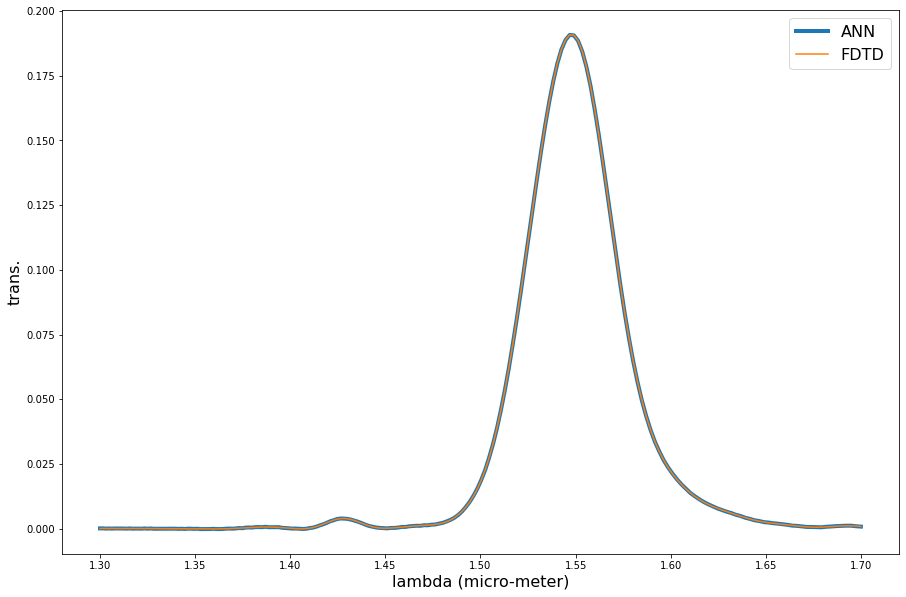

In [350]:
lambdas = np.flip(dataframe['lambda'][0])
plt.plot(lambdas, model.forward(x[0]).data, linewidth=4, label='ANN')
plt.plot(lambdas, y[0], label='FDTD')
plt.xlabel('lambda (micro-meter)', fontsize=16)
plt.ylabel('trans.', fontsize=16)
plt.legend(fontsize=16)